
# # Multimodal Brain Tumor Project — CNN + Transformer (Genomics) + Fusion
#
# **Goal:** Build a multimodal deep learning pipeline that fuses MRI imaging features (via a CNN) with genomic features (via a Transformer encoder) to predict a clinically meaningful label (here: neoplasm histologic grade).

In [11]:
import os
import re
import random
import logging
from pathlib import Path


import numpy as np
import pandas as pd
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Set up basic logging for debugging and reproducibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('multimodal')

In [31]:
# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [32]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

2025-10-04 09:44:34,636 - INFO - Using device: cpu


In [33]:
# Helper: safe image open
def pil_loader(path):
    with Image.open(path) as img:
        return img.convert('RGB')

### Section 1: Paths and quick checks ###

In [40]:
ROOT = Path('dataset')
CSV_PATH = ROOT / 'data.csv' # genomic + metadata CSV
IMG_ROOT = ROOT / 'kaggle_3m' # folder containing patient folders (one folder per case)
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

In [41]:
# Quick sanity checks
assert CSV_PATH.exists(), f"CSV not found at {CSV_PATH}. Put the genomic CSV at dataset/data.csv"
assert IMG_ROOT.exists(), f"Image root not found at {IMG_ROOT}. Put image folders under dataset/kaggle_3m/"


logger.info(f"CSV found: {CSV_PATH}")
logger.info(f"Image folders found under: {IMG_ROOT}")

2025-10-04 09:45:27,779 - INFO - CSV found: dataset/data.csv
2025-10-04 09:45:27,780 - INFO - Image folders found under: dataset/kaggle_3m


### Section 2: Load genomic CSV and inspect columns — choose features + target
We will predict `neoplasm_histologic_grade` as the target (common clinical label: grade II vs grade III). If you want a different target, change TARGET_COL below and re-run preprocessing.

In [42]:
genomic_df = pd.read_csv(CSV_PATH)
logger.info(f"Genomic CSV loaded: {genomic_df.shape[0]} rows, {genomic_df.shape[1]} cols")
logger.info(f"Columns: {list(genomic_df.columns)}")


display_sample = genomic_df.head(3)
print(display_sample.to_string(index=False))

2025-10-04 09:46:27,510 - INFO - Genomic CSV loaded: 110 rows, 18 cols
2025-10-04 09:46:27,511 - INFO - Columns: ['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster', 'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster', 'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site', 'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic', 'race', 'ethnicity', 'death01']


     Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  RPPACluster  OncosignCluster  COCCluster  histological_type  neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  gender  age_at_initial_pathologic  race  ethnicity  death01
TCGA_CS_4941            2.0                 4.0             2        2.0          NaN              3.0           2                1.0                        2.0                1.0         3.0             2.0     2.0                       67.0   3.0        2.0      1.0
TCGA_CS_4942            1.0                 5.0             2        1.0          1.0              2.0           1                1.0                        2.0                1.0         3.0             2.0     1.0                       44.0   2.0        NaN      1.0
TCGA_CS_4943            1.0                 5.0             2        1.0          2.0              2.0           1                1.0                        2.0                1.0         1.0  

In [ ]:
# Standardize column names: strip whitespace
# Ensures all column names are trimmed (no leading/trailing spaces)
genomic_df.columns = [c.strip() for c in genomic_df.columns]

In [ ]:
# Set which column is the patient id in the CSV
PATIENT_COL = 'Patient' # appears in  CSV, unique identifier for each patient. Used to match MRI images and genomic data.
TARGET_COL = 'neoplasm_histologic_grade' #this typically represents tumor grade (e.g., Grade II vs Grade III).

In [47]:
if PATIENT_COL not in genomic_df.columns:
    raise KeyError(f"Expected patient id column '{PATIENT_COL}' not found. Columns: {genomic_df.columns}")
if TARGET_COL not in genomic_df.columns:
    raise KeyError(f"Expected target column '{TARGET_COL}' not found. Columns: {genomic_df.columns}")

In [48]:
# Drop rows with missing target
before = genomic_df.shape[0]
genomic_df = genomic_df.dropna(subset=[TARGET_COL])
after = genomic_df.shape[0]
logger.info(f"Dropped {before-after} rows with missing target '{TARGET_COL}'. Remaining: {after}")

2025-10-04 10:09:15,839 - INFO - Dropped 1 rows with missing target 'neoplasm_histologic_grade'. Remaining: 109


In [50]:
# Normalize patient IDs
genomic_df[PATIENT_COL] = genomic_df[PATIENT_COL].astype(str).str.strip()
#Converts all patient IDs to string type (sometimes they’re numeric or contain spaces).

#.str.strip() removes extra spaces — ensuring IDs perfectly match MRI folder names like "TCGA_DU_5851".

In [ ]:
# Inspect unique targets
#Shows what unique classes your target has.

#e.g., ['G2', 'G3'] for Grade II and Grade III tumors.
logger.info(f"Unique target values: {sorted(genomic_df[TARGET_COL].dropna().unique().tolist())}")

2025-10-04 13:09:52,218 - INFO - Unique target values: [1.0, 2.0]


In [ ]:
# Map target to integer labels (0..K-1)
#Machine learning models need numbers, not text labels.

#This creates a dictionary mapping:{'G2': 0, 'G3': 1}
#Then we apply that mapping to create a new column 'label' in the dataframe: G2 → 0, G3 → 1

#So now the model can train on numeric labels while you still keep the readable 'neoplasm_histologic_grade' column for reference.
label_map = {v: i for i, v in enumerate(sorted(genomic_df[TARGET_COL].unique()))}
logger.info(f"Label map: {label_map}")
genomic_df['label'] = genomic_df[TARGET_COL].map(label_map)

2025-10-04 13:11:20,930 - INFO - Label map: {np.float64(1.0): 0, np.float64(2.0): 1}



### Section 3: Prepare genomic features
We'll pick several cluster columns + age + gender. Categorical columns will be one-hot encoded; numeric columns will be standardized.
Change `GENOMIC_FEATURE_COLS` to tune which genomic features to include.


In [ ]:
#These columns are important genomic and clinical features.

#The cluster columns (RNASeqCluster, MethylationCluster, etc.) describe different types of genetic activity.
#age_at_initial_pathologic is numeric (patient’s age).
#gender is categorical (male/female).

GENOMIC_FEATURE_COLS = [
'RNASeqCluster','MethylationCluster','miRNACluster','CNCluster',
'OncosignCluster','COCCluster','age_at_initial_pathologic','gender'
]

In [55]:
# Filter only columns that exist in the CSV (safety)
#This is a safety check so the code doesn’t fail if a column is missing.
#The logger shows which columns are actually being used.
GENOMIC_FEATURE_COLS = [c for c in GENOMIC_FEATURE_COLS if c in genomic_df.columns]
logger.info(f"Using genomic columns: {GENOMIC_FEATURE_COLS}")

2025-10-04 13:23:52,359 - INFO - Using genomic columns: ['RNASeqCluster', 'MethylationCluster', 'miRNACluster', 'CNCluster', 'OncosignCluster', 'COCCluster', 'age_at_initial_pathologic', 'gender']


In [56]:
# Fillna for categorical by a placeholder
gdf = genomic_df.copy()
for c in GENOMIC_FEATURE_COLS:
    if gdf[c].dtype == object or gdf[c].dtype.name == 'category':
        gdf[c] = gdf[c].fillna('missing')
    else:
        gdf[c] = gdf[c].fillna(gdf[c].median())

In [57]:
# One-hot encode categorical values and keep numeric ones
#Categorical features need to be converted to numbers.

#One-hot encoding turns a category into multiple columns with 0/1. Example:
gencat = pd.get_dummies(gdf[GENOMIC_FEATURE_COLS].astype(str), dummy_na=False)
logger.info(f"Genomic feature matrix shape after one-hot: {gencat.shape}")

2025-10-04 13:26:35,890 - INFO - Genomic feature matrix shape after one-hot: (109, 69)


In [58]:
# Standardize features
#Standardization makes mean = 0, standard deviation = 1.

#This is important so that the model treats all features equally.
scaler = StandardScaler()
genomic_features = scaler.fit_transform(gencat.values)

In [59]:
# Construct a DataFrame mapping patient -> feature vector
#Each row = patient, each column = feature.

genomic_features_df = pd.DataFrame(genomic_features, index=gdf[PATIENT_COL], columns=gencat.columns)

In [60]:
#You can get the features for one patient:
genomic_features_df.loc['TCGA_CS_4942']

RNASeqCluster_1.0                 1.833030
RNASeqCluster_2.0                -0.838525
RNASeqCluster_3.0                -0.351726
RNASeqCluster_4.0                -0.573819
MethylationCluster_1.0           -0.195180
                                    ...   
age_at_initial_pathologic_69.0   -0.096225
age_at_initial_pathologic_70.0   -0.168232
age_at_initial_pathologic_75.0   -0.096225
gender_1.0                        0.972846
gender_2.0                       -0.972846
Name: TCGA_CS_4942, Length: 69, dtype: float64

In [61]:
# Quick debug prints
logger.info(f"Example genomic features for patient {gdf[PATIENT_COL].iloc[0]}:\n{genomic_features_df.iloc[0,:10].to_dict()}")

2025-10-04 13:27:02,789 - INFO - Example genomic features for patient TCGA_CS_4941:
{'RNASeqCluster_1.0': -0.545544725589981, 'RNASeqCluster_2.0': 1.1925695879998877, 'RNASeqCluster_3.0': -0.3517262290563295, 'RNASeqCluster_4.0': -0.5738190417570046, 'MethylationCluster_1.0': -0.19518001458970663, 'MethylationCluster_2.0': -0.3679900360969936, 'MethylationCluster_3.0': -0.6733003292241386, 'MethylationCluster_4.0': 1.9886038958388508, 'MethylationCluster_5.0': -0.7022468831767836, 'miRNACluster_1': -0.6589465276604691}


### Section 4: Scan image folders and map patient IDs to image paths
We will extract patient IDs from folder names using: patient_id = "_".join(folder.split('_')[:3]) => e.g. TCGA_CS_4941
Inside each patient folder we will pick the middle slice as representative.


In [62]:
# List patient folders under IMG_ROOT
folders = [p for p in sorted(IMG_ROOT.iterdir()) if p.is_dir()]
logger.info(f"Found {len(folders)} patient folders under {IMG_ROOT}")

2025-10-04 14:01:29,445 - INFO - Found 29 patient folders under dataset/kaggle_3m


In [63]:
# Build map: patient_id -> list of image file paths
patient_to_images = {}
for folder in folders:
    fname = folder.name
    # Extract patient id as first 3 tokens joined by underscore, e.g. TCGA_CS_4941
    parts = fname.split('_')
    if len(parts) >= 3:
        patient_id = '_'.join(parts[:3])
    else:
        patient_id = fname


    # collect tif/jpg/png files
    img_files = sorted([str(p) for p in folder.glob('*.tif')] + [str(p) for p in folder.glob('*.png')] + [str(p) for p in folder.glob('*.jpg')])
    if len(img_files) == 0:
        continue
    patient_to_images.setdefault(patient_id, []).extend(img_files)


logger.info(f"Mapped {len(patient_to_images)} unique patient IDs from folders (after normalization)")

2025-10-04 14:02:39,698 - INFO - Mapped 29 unique patient IDs from folders (after normalization)


In [64]:
# Show a couple of patients and the number of slices
sample_items = list(patient_to_images.items())[:5]
for pid, imgs in sample_items:
    logger.info(f"Patient {pid}: {len(imgs)} slices, example: {imgs[:2]}")

2025-10-04 15:07:50,506 - INFO - Patient TCGA_CS_4941: 46 slices, example: ['dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', 'dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif']
2025-10-04 15:07:50,508 - INFO - Patient TCGA_CS_4942: 40 slices, example: ['dataset/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif', 'dataset/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10.tif']
2025-10-04 15:07:50,509 - INFO - Patient TCGA_CS_4943: 40 slices, example: ['dataset/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif', 'dataset/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10.tif']
2025-10-04 15:07:50,509 - INFO - Patient TCGA_CS_4944: 40 slices, example: ['dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif']
2025-10-04 15:07:50,510 - INFO - Patient TCGA_CS_5393: 40 slices, example: ['dataset/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS

### Section 5: Match genomic patients and MRI patients — keep only common patients

In [65]:
csv_patients = set(genomic_features_df.index.tolist())
img_patients = set(patient_to_images.keys())


patients_common = sorted(list(csv_patients.intersection(img_patients)))
patients_only_csv = sorted(list(csv_patients - img_patients))
patients_only_img = sorted(list(img_patients - csv_patients))


logger.info(f"Patients only in CSV: {len(patients_only_csv)}")
logger.info(f"Patients only in IMG: {len(patients_only_img)}")
logger.info(f"Patients in both: {len(patients_common)}")

2025-10-04 20:28:29,961 - INFO - Patients only in CSV: 80
2025-10-04 20:28:29,963 - INFO - Patients only in IMG: 0
2025-10-04 20:28:29,963 - INFO - Patients in both: 29


In [66]:
# Print example common patients
logger.info(f"Examples of common patients: {patients_common[:10]}")


if len(patients_common) < 10:
    logger.warning("Small number of matched patients. Your experimental power could be limited. Proceeding for demonstration.")

2025-10-04 20:30:22,944 - INFO - Examples of common patients: ['TCGA_CS_4941', 'TCGA_CS_4942', 'TCGA_CS_4943', 'TCGA_CS_4944', 'TCGA_CS_5393', 'TCGA_CS_5395', 'TCGA_CS_5396', 'TCGA_CS_5397', 'TCGA_CS_6186', 'TCGA_CS_6188']


In [67]:
# Filter genomic dataframe to only those patients
genomic_features_df = genomic_features_df.loc[[p for p in patients_common if p in genomic_features_df.index]]
labels_series = genomic_df.set_index(PATIENT_COL).loc[genomic_features_df.index, 'label']

In [ ]:
# Quick check
# Prints the final number of patients that have both genomic and MRI data.
logger.info(f"Final number of paired patients (genomic+imaging): {len(genomic_features_df)}")

2025-10-04 20:32:31,999 - INFO - Final number of paired patients (genomic+imaging): 29


### Section 6: Build Dataset class that returns (image, genomic_vector, label)
We choose one representative slice per patient (the middle slice). If you prefer another strategy (all slices, random slice, or combine slices), you can change the sampler logic below.


In [69]:
class MultimodalPatientDataset(Dataset):
    def __init__(self, patient_ids, patient_to_images, genomic_features_df, labels_series, transform=None):
        self.patient_ids = list(patient_ids)
        self.patient_to_images = patient_to_images
        self.genomic_features_df = genomic_features_df
        self.labels_series = labels_series
        self.transform = transform


    def __len__(self):
        return len(self.patient_ids)


    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        imgs = sorted(self.patient_to_images[pid])
        # pick middle slice
        img_path = imgs[len(imgs) // 2]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        # genomic vector
        genomic_vec = torch.tensor(self.genomic_features_df.loc[pid].values, dtype=torch.float32)
        label = int(self.labels_series.loc[pid])
        return image, genomic_vec, label

### Section 7: Create train/test split of patients and DataLoaders
We split at patient-level so that slices from same patient don't leak between train and test.

In [70]:
patient_ids = genomic_features_df.index.tolist()
labels_for_split = labels_series.loc[patient_ids].values


train_patients, test_patients = train_test_split(patient_ids, test_size=0.25, random_state=RANDOM_SEED, stratify=labels_for_split)
logger.info(f"Train patients: {len(train_patients)}, Test patients: {len(test_patients)}")

2025-10-04 20:42:49,963 - INFO - Train patients: 21, Test patients: 8


In [71]:
# Image transforms
img_size = 128
train_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [72]:
# Create datasets
train_dataset = MultimodalPatientDataset(train_patients, patient_to_images, genomic_features_df, labels_series, transform=train_transform)
test_dataset = MultimodalPatientDataset(test_patients, patient_to_images, genomic_features_df, labels_series, transform=test_transform)

In [73]:
# DataLoaders (num_workers=0 to avoid macOS spawn issues; change to >0 if safe)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


logger.info(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

2025-10-04 20:43:48,782 - INFO - Train samples: 21, Test samples: 8


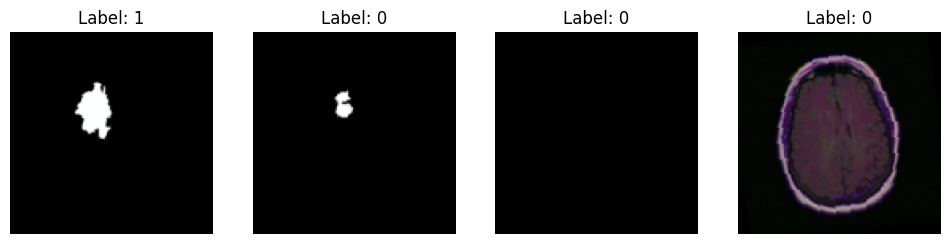

In [74]:
# Visualize a few samples (debugging/visualization)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, min(4, len(train_dataset)), figsize=(12,3))
for i in range(min(4, len(train_dataset))):
    img, gvec, lbl = train_dataset[i]
    # unnormalize for display
    img_disp = img.numpy().transpose((1,2,0))
    img_disp = img_disp * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_disp = np.clip(img_disp, 0, 1)
    axes[i].imshow(img_disp)
    axes[i].set_title(f"Label: {lbl}")
    axes[i].axis('off')
plt.show()